# Loading required R libraries and loading the data
First, we installed the required R libraries and then we loaded the CSV data and converted it to RData for quicker loading and processing.


In [11]:
#install.packages("ROCR")
#suppressWarnings(library(ROCR))
#suppressWarnings(library(mgcv))

In [1]:
df_train <- read.csv('DSCH_TRAIN_dataset.csv', sep=';', dec=',')
df_test <- read.csv('DSCH_TEST_dataset.csv', sep=';', dec=',')
#save(df_train, file='df_train.RData')
#save(df_train, file='df_test.RData')


# Model preparation

## Variable assignments
We categorized the variables according to their types. However, we found out that PERSON_20_REAL had int values and was better suited for the int variables category. We later converted the variables to fit the category type.


In [ ]:
features_cat <- c('CAR_2_NOM','CAR_3_NOM','CAR_8_NOM','CAR_10_NOM','CAR_11_NOM','CAR_12_NOM','CAR_13_NOM','CAR_14_NOM','CAR_17_NOM','CAR_30_NOM','GEO_1_NOM','INS_HISTORY_19_NOM','INS_HISTORY_31_NOM','OTHER_2_NOM',
                  'OTHER_3_NOM','OTHER_4_NOM','PERSON_7_NOM','PERSON_9_NOM','PERSON_10_NOM','PERSON_13_NOM','POLICY_DATA_3_NOM','POLICY_DATA_5_NOM','POLICY_DATA_6_NOM','POLICY_DATA_9_NOM')

for (v in features_cat) {
  df_train[,v] <- as.factor(df_train[,v])
  df_test[,v] <- as.factor(df_test[,v])
}

features_int <- c('CAR_1_INT','CAR_6_INT','PERSON_20_REAL','CAR_7_INT','CAR_9_INT','CAR_15_INT','CAR_16_INT','CAR_18_INT','CAR_19_INT','CAR_20_INT','CAR_21_INT','CAR_22_INT','CAR_23_INT','CAR_24_INT','CAR_25_INT',
                  'CAR_26_INT','CAR_27_INT','CAR_28_INT','CAR_29_INT','CAR_31_INT','INS_HISTORY_5_INT','INS_HISTORY_6_INT','INS_HISTORY_9_INT','INS_HISTORY_10_INT','INS_HISTORY_11_INT','INS_HISTORY_12_INT','INS_HISTORY_13_INT',
                  'INS_HISTORY_14_INT','INS_HISTORY_15_INT','INS_HISTORY_16_INT','INS_HISTORY_17_INT','INS_HISTORY_18_INT','INS_HISTORY_30_INT','OTHER_1_INT','OTHER_5_INT','PERSON_5_INT','PERSON_6_INT','PERSON_8_INT',
                  'PERSON_11_INT','PERSON_12_INT','PERSON_14_INT','PERSON_15_INT','PERSON_16_INT','PERSON_17_INT','PERSON_18_INT','PERSON_19_INT','PERSON_21_INT','PERSON_22_INT','PERSON_23_INT','PERSON_24_INT','PERSON_25_INT',
                  'PERSON_26_INT','PERSON_27_INT','PERSON_28_INT','PERSON_29_INT','PERSON_30_INT','PERSON_31_INT','PERSON_32_INT','PERSON_33_INT','PERSON_34_INT','PERSON_35_INT','PERSON_36_INT','PERSON_37_INT','PERSON_38_INT',
                  'PERSON_39_INT','PERSON_40_INT','PERSON_41_INT','PERSON_42_INT','PERSON_43_INT','PERSON_44_INT','PERSON_45_INT','PERSON_46_INT','PERSON_47_INT','PERSON_48_INT','PERSON_49_INT','PERSON_50_INT','PERSON_51_INT',
                  'PERSON_52_INT','PERSON_53_INT','PERSON_54_INT','PERSON_55_INT','PERSON_56_INT','PERSON_57_INT','PERSON_58_INT','PERSON_59_INT','PERSON_60_INT','POLICY_DATA_1_INT','POLICY_DATA_2_INT','POLICY_DATA_4_INT',
                  'POLICY_DATA_7_INT','POLICY_DATA_8_INT')

for (v in features_int) {
  df_train[,v] <- as.integer(df_train[,v])
  df_test[,v] <- as.integer(df_test[,v])
}


features_num <- c('CAR_4_REAL','INS_HISTORY_1_REAL','INS_HISTORY_20_REAL','INS_HISTORY_21_REAL','INS_HISTORY_22_REAL','INS_HISTORY_23_REAL','INS_HISTORY_24_REAL','INS_HISTORY_25_REAL','INS_HISTORY_26_REAL','INS_HISTORY_27_REAL',
                  'INS_HISTORY_28_REAL','INS_HISTORY_29_REAL','INS_HISTORY_2_REAL','INS_HISTORY_3_REAL','INS_HISTORY_4_REAL','INS_HISTORY_7_REAL','INS_HISTORY_8_REAL','PERSON_1_REAL','PERSON_2_REAL','PERSON_3_REAL','PERSON_4_REAL',
                  'CURRENT_MODEL_REAL')

df_train$CLAIMS_REAL <- as.factor(df_train$CLAIMS_REAL)

## Issues with including exposure as a standard feature
Since there were no detailed information provided about the variables we decided not to exclude any variables, aiming for not to miss any aspects. However, we decided not to include exposure as a covariate due to strong dependency with loss occurrence. Looking at the plot below we see that there is a peak in claims frequency around exposure of 0.25 (3 months). We do not expect that an exposure value of 0.25 should be predictive.


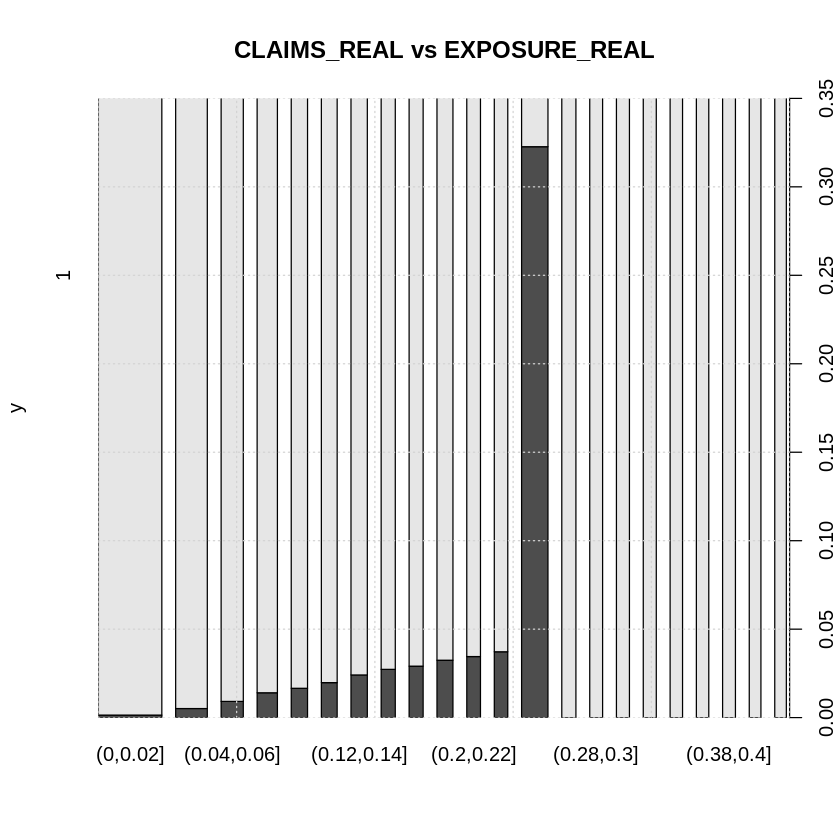

In [6]:
plot(cut(df_train$EXPOSURE_REAL, breaks=seq(0,1,0.02)), df_train$CLAIMS_REAL,
xlab='', las=2,
main='CLAIMS_REAL vs EXPOSURE_REAL',xlim=c(0,1),
ylim=c(0,0.35)); grid()

## Creating model formula

Here we create a formula for our model. We decided to include the current model provided by UNIQA as suggested.

In [5]:
predictors <- c(features_cat, features_int, features_num)
formula <- as.formula(paste('CLAIMS_REAL', '~', paste(features_cat,collapse=' + '),
                                    ' + ',paste(features_int,collapse=' + '),
                                    ' + s(',paste(features_num,collapse=') + s('),')' ))


## Model
Since our target variable is binary a logistic model would be suitable, however, to have the possibility to scale our predictions intuitively to annual basis and since claims are expected to follow a poisson like distribution we decided to use a Poisson model. Our predictions would be interpreted as the expected amount of claims per policy which we afterwards transform into probabilities.

We generated multiple GLMs / GAMs. The initial challenge was to still make use of exposure. We decided to model rates instead of counts, hence we divided claims by exposure in our poisson model which is equivalent to including it as an offset in our GAM (we use the bam function to create a GAM, this is recommended for big data sets). This is due to the fact that e.g. the expected amount of claims should be 0.4 for a given borderaux with 0.1 expected claims in 0.25 years of exposure.


In [4]:
model <- mgcv::bam(formula = formula,data = df_train,
                   family = "poisson", offset = log(df_train$EXPOSURE_REAL)) 

# Model assessment
The next step was to assess our model. To do so we multiply our predictions by exposure to compare against actual claims, we later convert our prediction into probabilities using the approximate Poisson assumption distribution and obtain the GINI coefficient.


## Calculating probabilities


In [7]:
pred_annual_log <- predict(model,df_train)

#Convert log to predicted claims and scaling by exposure
pred <- exp(pred_annual_log)

#Convert to probabilities
#Poisson: E(N) = lambda
#         P(N>=1) = 1-exp(-lambda) = 1-exp(E(N))
prob <- 1-exp(-pred)

## GINI
To assess the model we plotted the ROC curve and calculated the GINI coefficient. To do that in R we use the library ROCR and create a prediction as well as performance objects as follows.

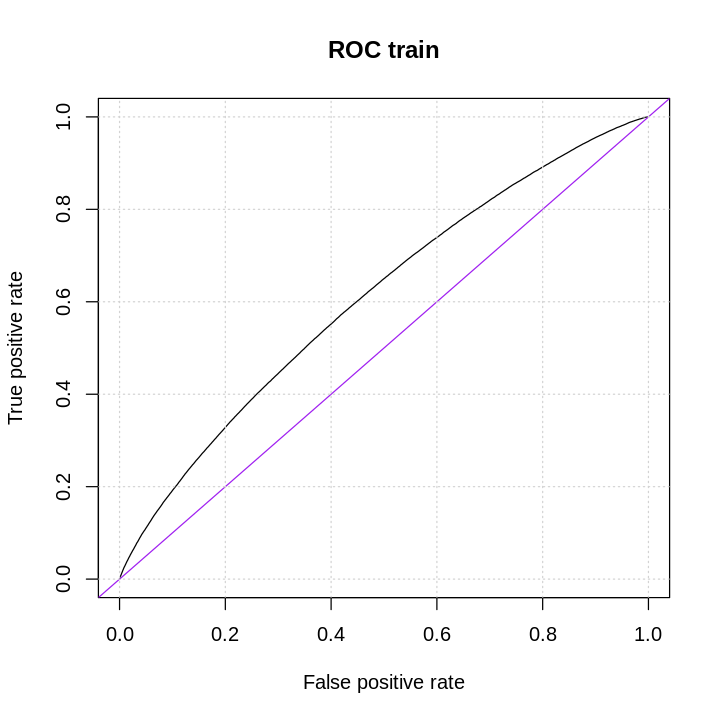

In [8]:
#Creating prediction object and roc_curve for plotting
prediction <- prediction(as.numeric(prob),as.numeric(df_train$CLAIMS_REAL))
roc_curve <- performance(prediction,'tpr','fpr')

#Plotting the ROC curve
options(repr.plot.width=6, repr.plot.height=6) #scale plot for pdf output
plot(roc_curve, main='ROC train')
abline(0,1,col='purple')
grid()


In [9]:
#Calculating and printing the GINI coefficient of our model
GINI <- 2*performance(prediction, 'auc' )@y.values[[1]]-1
print(paste("GINI coefficient of our model =",GINI))
      
#Calculating and printing the GINI coefficient of our model
prediction_curr <- prediction(as.numeric(df_train$CURRENT_MODEL_REAL),as.numeric(df_train$CLAIMS_REAL))
GINI_curr <- 2*performance(prediction_curr, 'auc' )@y.values[[1]]-1
print(paste("GINI coefficent of the current model =",GINI_curr))

[1] "GINI coefficient of our model = 0.218909643561104"
[1] "GINI coefficent of the current model = 0.21482837118737"


## Comparison against the current model
As we cannot compare our model to actual claims from the test dataset we decided to plot our predictions against the current model. We can see that especially for small amounts of expected annual claims the predictions have a high correlation. However, our model would in general tend to predict more claims than predicted by the current model.


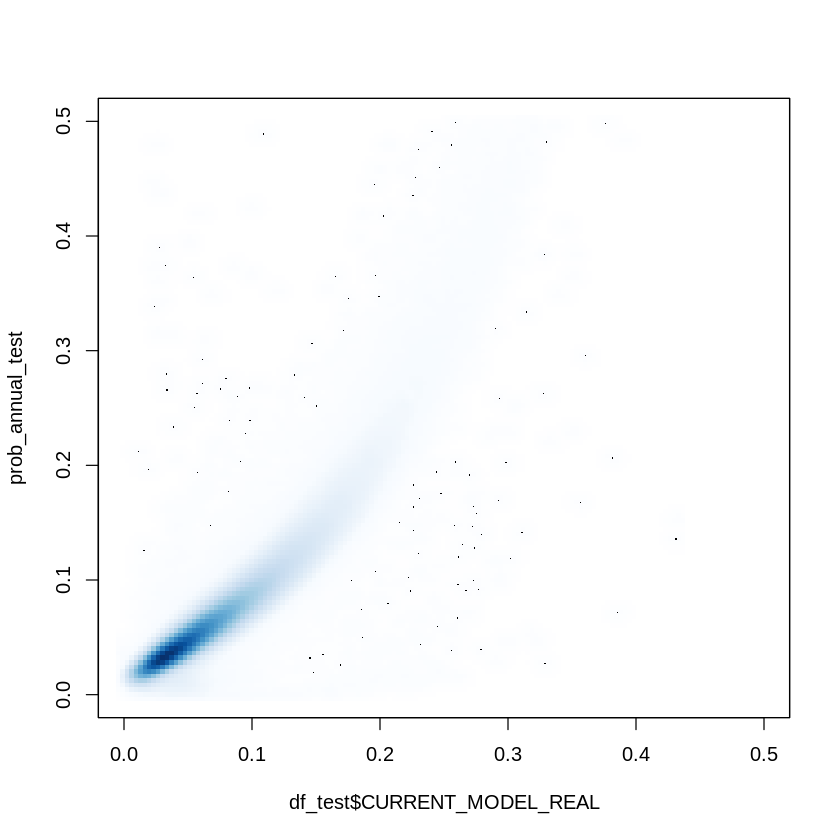

In [4]:
#Annual predictions
pred_annual_log_test <- predict(model,df_test)
pred_annual_test <- exp(pred_annual_log_test)

#Convert to probabilities
prob_annual_test <- 1-exp(-pred_annual_test)
final_predictions <- prob_annual_test

#Plotting the comparison
smoothScatter(df_test$CURRENT_MODEL_REAL, prob_annual_test,
xlim=c(0,0.5),ylim=c(0,0.5))


## Variable Importance
Here we present the top 5 important variables without as well as with smoothing parameters sorted by the p-value and the chi squared value, respectively, and their histograms. The interpretation can be found in the pdf uploaded together with this notebook.


In [3]:
print(head(sort(mgcv::summary.gam(model)$p.pv),5))

     PERSON_19_INT      PERSON_18_INT         CAR_23_INT POLICY_DATA_3_NOM2 
      1.105198e-06       7.108405e-06       3.031080e-05       1.148068e-04 
      CAR_13_NOM31 
      2.658480e-04 


In [ ]:
# PERSON_19_INT
plot(model,select=92,all.terms=T)
hist(df_train$PERSON_19_INT)

# PERSON_18_INT
plot(model,select=91,all.terms=T)
hist(df_train$PERSON_18_INT)

# CAR_23_INT
plot(model,select=59,all.terms=T)
hist(df_train$CAR_23_INT)

# POLICY_DATA_3_NOM
plot(model,select=43,all.terms=T)
plot(df_train$POLICY_DATA_3_NOM)

# CAR_13_NOM
plot(model,select=29,all.terms=T)
plot(df_train$CAR_13_NOM)

Next we present the most important numeric variables. As expected, the current model is the most important predictor.

In [6]:
summary <- summary.gam(model)
print(head(sort(summary$chi.sq,decreasing = T),5))

 s(CURRENT_MODEL_REAL) s(INS_HISTORY_20_REAL)          s(CAR_4_REAL) 
           3739.634212              19.487488              18.077913 
s(INS_HISTORY_24_REAL) s(INS_HISTORY_26_REAL) 
              7.182759               5.623634 


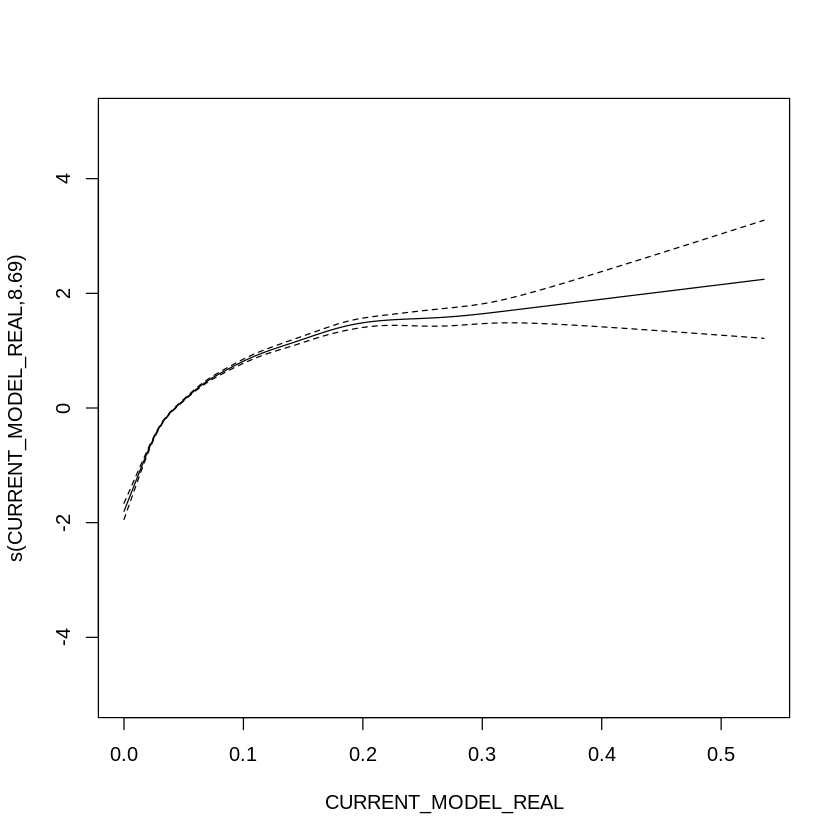

In [6]:
# CURRENT_MODEL_REAL
plot(model,select=22,ylim=c(-5,5))

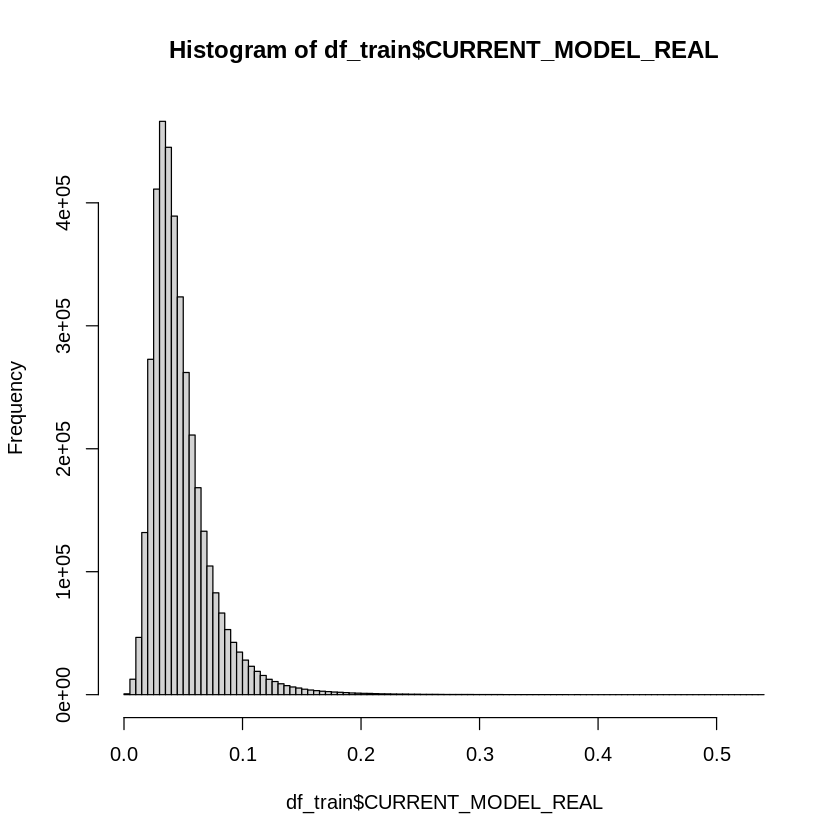

In [2]:
# CURRENT_MODEL_REAL histogram
hist(df_train$CURRENT_MODEL_REAL,breaks=100)

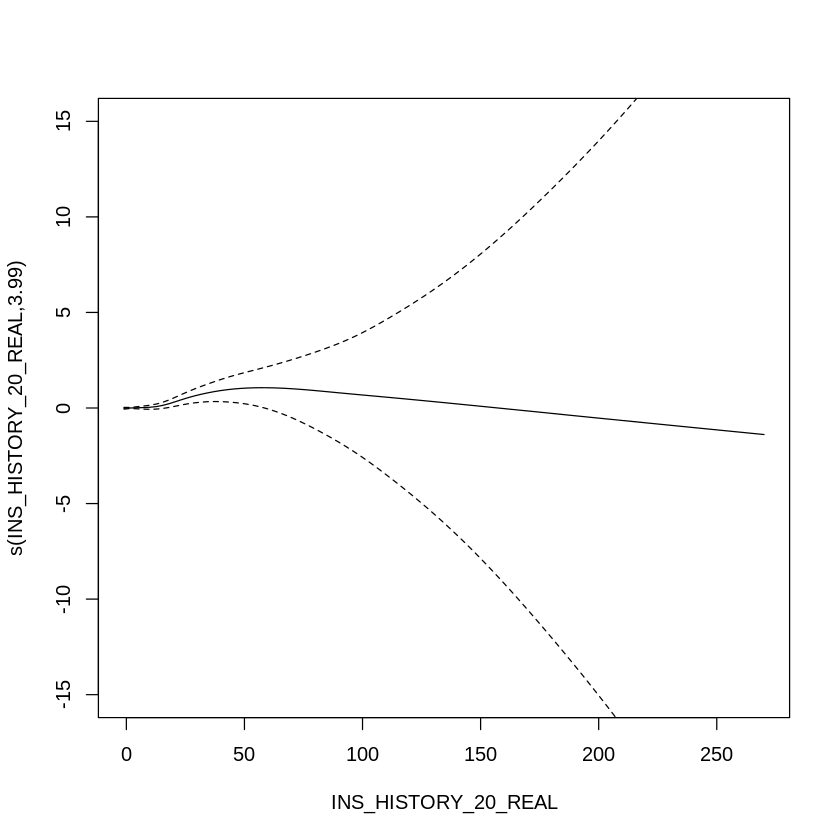

In [7]:
# INS_HISTORY_20_REAL
plot(model,select=3,ylim=c(-15,15))

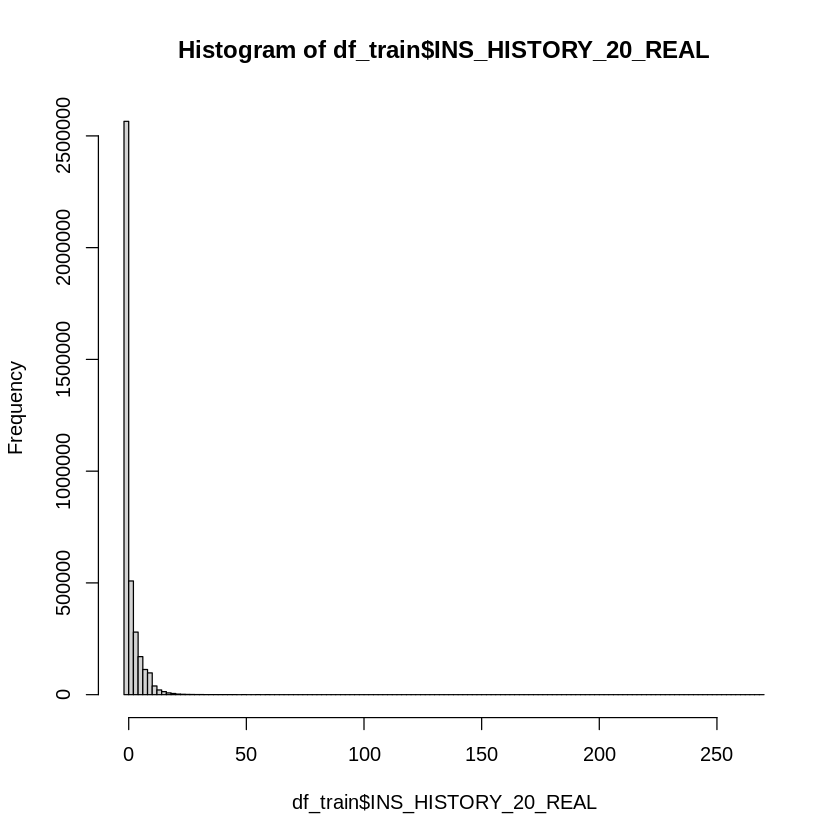

In [3]:
# INS_HISTORY_20_REAL histogram
hist(df_train$INS_HISTORY_20_REAL,breaks=100)

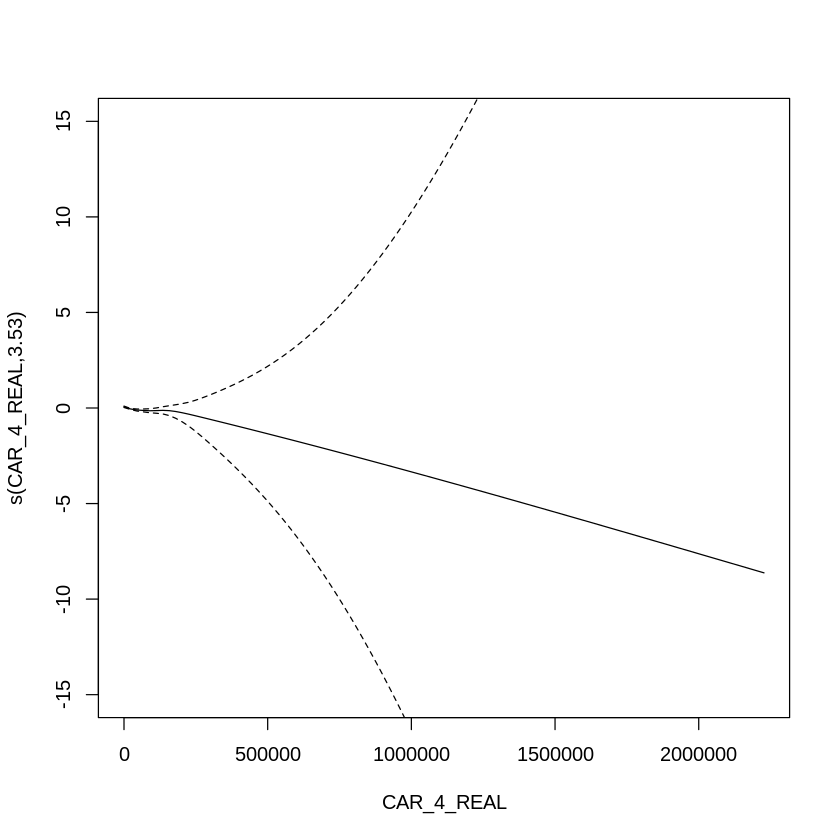

In [8]:
# CAR_4_REAL
plot(model,select=1,ylim=c(-15,15))

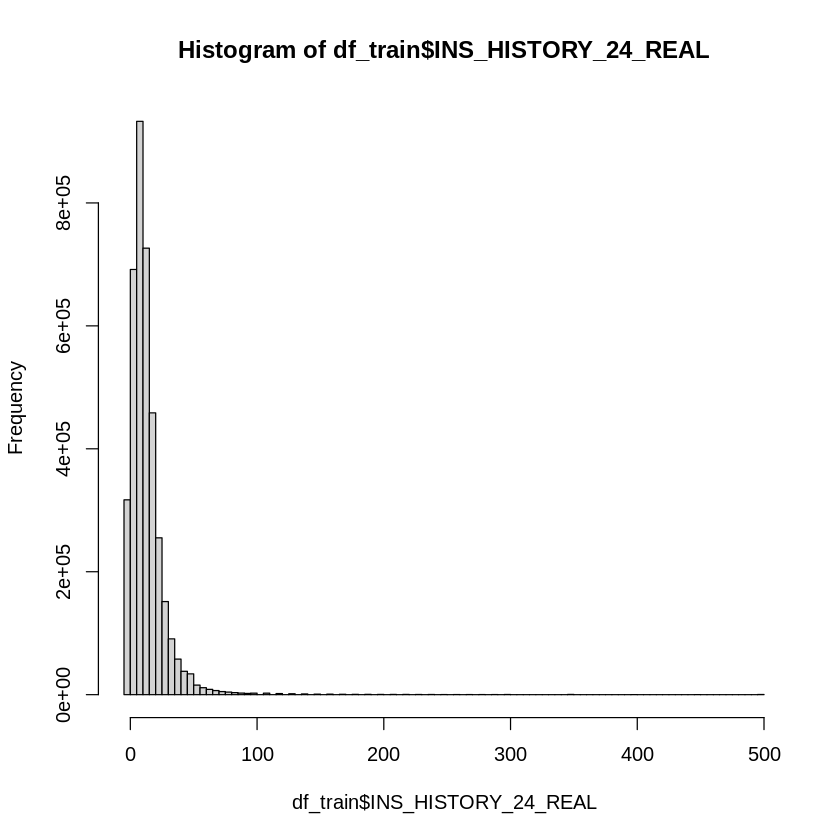

In [4]:
# CAR_4_REAL histogram
hist(df_train$INS_HISTORY_24_REAL,breaks=100)

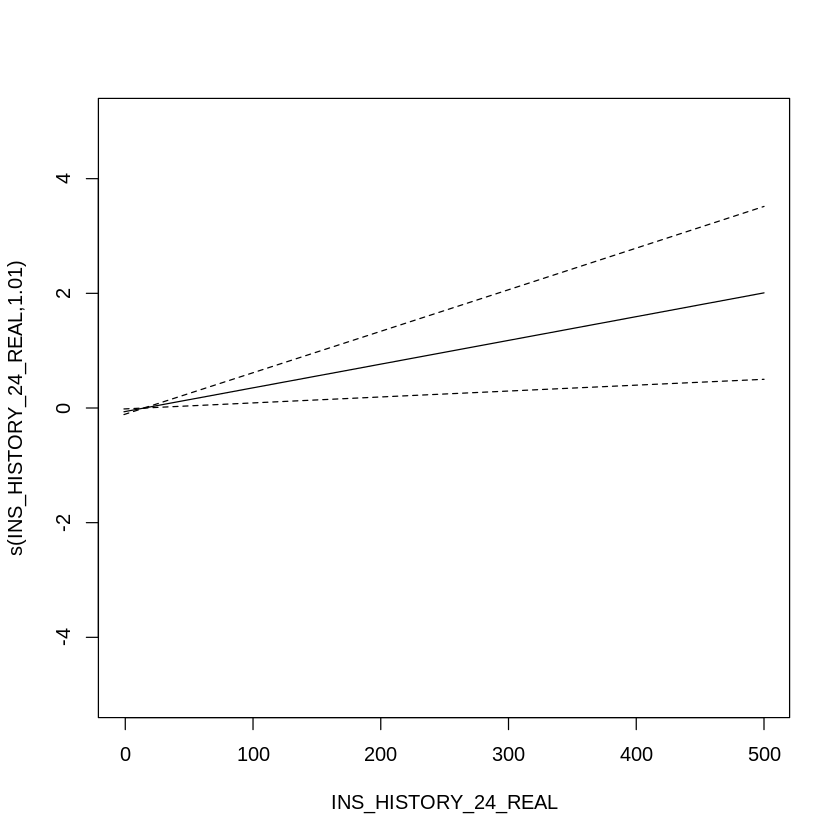

In [9]:
# INS_HISTORY_24_REAL
plot(model,select=7,ylim=c(-5,5))

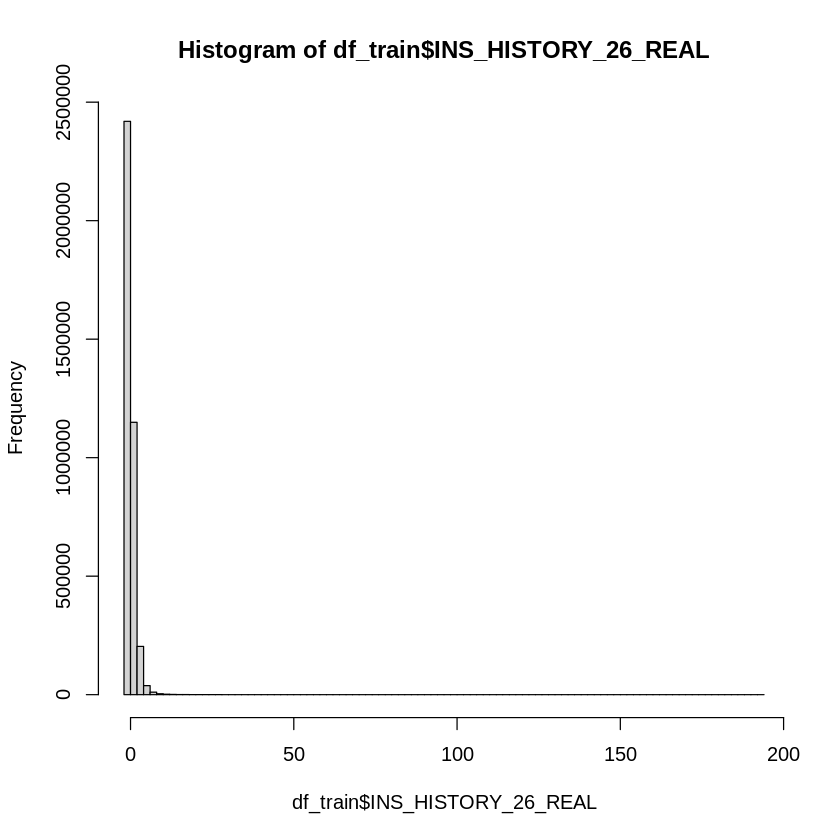

In [5]:
# INS_HISTORY_24_REAL histogram
hist(df_train$INS_HISTORY_26_REAL,breaks=100)

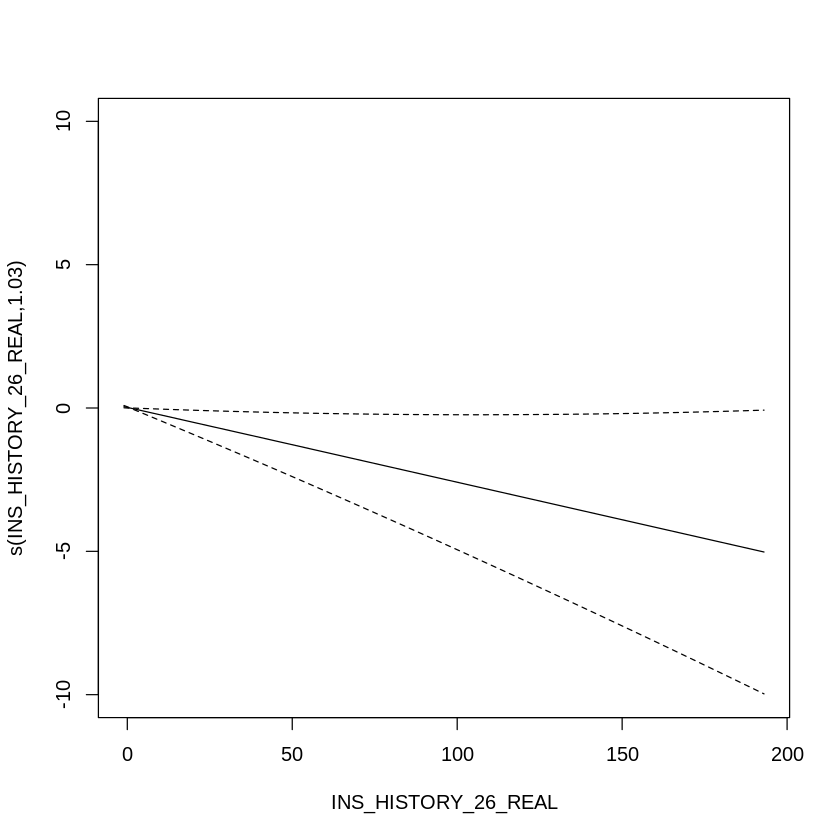

In [10]:
# INS_HISTORY_26_REAL
plot(model,select=9,ylim=c(-10,10))

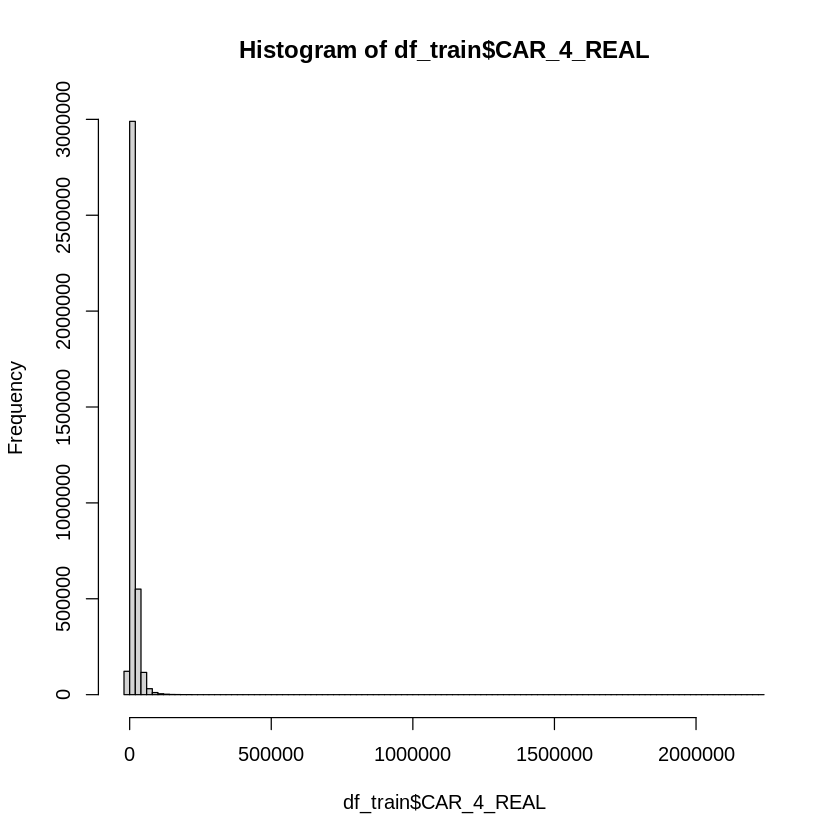

In [6]:
# INS_HISTORY_26_REAL histogram
hist(df_train$CAR_4_REAL,breaks=100)